# Correlation Between Semantic Similarity and Wikipedia Distance
### CMSC 320, Spring 2022
#### Ben Landrum, Gaetan Almela, and Nav Bindra



The Wikipedia link graph is a graph where vertices represent Wikipedia articles and directed edges from vertex $A$ to vertex $B$ represent a link to $B$ in the text of $A$. We define Wikipedia distance between pages $A$ and $B$ to be the minimum number of links required to get from $A$ to $B$ in the Wikipedia link graph, where the first such link is on page $A$, the second is on the page the first link points to, and so on, until a link to $B$ is found.

Word2Vec is a popular tool for computing word embeddings, which use a vector space representation of words to place them in an abstract space where similar vectors indicate that words appear in similar contexts. These vectors can then be compared to find a metric of semantic similarity between words. 

Because pages on Wikipedia contain links which are relevant to the topic the page is covering, similar topics are often closely if not directly linked. Therefore, it stands to reason that if semantic similarity is a valid metric of similarity between topics, a higher semantic similarity between two topics should correspond to a lower Wikipedia distance between said topics. We are looking to test the hypothesis that there exists a negative correlation between Wikipedia distance and Word2Vec semantic similarity. Our null hypothesis is that there does not exist a statistically significant negative correlation between Wikipedia distance and Word2Vec semantic similarity.

In [117]:
from bs4 import BeautifulSoup
from requests import get
from faker import Faker

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
from scipy.stats import spearmanr

import time
import re
import os
from pathlib import Path
import datetime
import warnings

from gensim.models import KeyedVectors

## Computing Wikipedia Distance

### Top $n$ Wikipedia Articles

English Wikipedia has over 6 million articles. A graph describing the links between all of them would be prohibitively large, so we will only consider the top $n = 1000$ articles. Note that this cna be scaled up to a larger $n$ with little to no modification to the project, but we chose $n = 1000$ as a compromise between result accuracy and space/time efficiency.

Wikipedia provides data dumps describing page views in the form of files tallying how many views each page received in a given hour. These files are available [here](https://dumps.wikimedia.org/other/pageviews/), and date back to May 1st, 2015. The most popular pages on Wikipedia at any given time are generally determined by current events, so to factor out this bias and get a representative sample of the most popular articles we want to sample the largest possible time period, in this case May 1st, 2015 to present day.

Before jumping directly into collecting the pages, we first define some constants. We define a file structure for downloading our (quite large amounts of) data, as well as certain switches used to toggle certain parts of the data collection pipeline.

Our data collection process was long and painful, to avoid passing on this long process to anyone trying our analysis, we have provided global variables such as `GET_POP_PAGES`, `DOWNLOAD_PAGES`, and `BUILD_GRAPH`. If the user so chooses, they may toggle these constants which would query the $N$ most popular Wikipedia pages, download them, and construct a connection graph. For the sake of this anaylsis, we will be working with pre-generated files: `wiki_top.csv.gz` for our top $1000$ pages, and `wiki_graph.gml` for our connection graph of these pages.

In [118]:
ENGLISH_WIKIS = ['en', 'en.m'] # desktop and mobile versions of english wikipedia
PAGE_TYPE_REGEX = r'^((User)|(Talk)|(Wikipedia)|(Special)|(Portal)|(File)):' # regex for filtering non-article pages

N = 10 ** 4 # number of pages to return (10,000)
RANDOM_FILES = 0 # Number of random files to use

######################
#   File Structure   #
######################
DATA_DIR = 'data'

# pre generated csv of top 1,000 most popular wikipedia pages
CACHED_PAGEVIEWS = 'wiki_top.csv.gz'

# pre generated graph of the connections between the top 1000 wikipedia pages
GRAPH_FILENAME = 'wiki_graph.gml'

# our semantic similarity model file, explained later in the project
SEM_MODEL = 'crawl-300d-2M.vec'
COMPILED_MODEL = 'crawl-300d-2M.d2v'

# there constants are only here for the preview. Since this document would take
# hours to run, its easier to skip the data collection part and go straight to
# the analysis.
GET_POP_PAGES = False
DOWNLOAD_PAGES = False
BUILD_GRAPH = False

In [119]:
# creating a Faker object which will later be used to generate random datetimes
fake = Faker()

# suppressing a warning caused by use of match groups in a regex 
warnings.filterwarnings('ignore', message="This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.")

# generate a random datetime for which there exists a pageview file
date = fake.date_time_between(start_date=datetime.datetime(year=2015, month=5, day=1, hour=1), end_date='now')

if GET_POP_PAGES:
    # get the url of the corresponding pageview file
    url = f"https://dumps.wikimedia.org/other/pageviews/{date.year}/{date.year}-{date.month:02d}/pageviews-{date.strftime('%Y%m%d')}-{date.hour:02d}0000.gz"

    # download and save the file
    seed_file = f"{DATA_DIR}/pageviews-{date.strftime('%Y%m%d')}-{date.hour:02d}0000.gz"
    r = get(url)
    with open(seed_file, 'wb') as f:
        f.write(r.content)

    # importing first file to accumulate the others from
    all_views = pd.read_csv(seed_file, sep=" ", header=None, names=["project", "page", "views", "null"], usecols=["project", "page", "views"])

    # filtering to only pages from english wikipedia, both desktop and mobile
    en_views = all_views[all_views['project'].isin(ENGLISH_WIKIS)]
    # filtering user, talk and other non-article pages
    views = en_views[~(en_views['page'].str.contains(PAGE_TYPE_REGEX, na=False))]

    # computing views for each page 
    views = views.groupby('page').sum()

Now we get the random files and add their views to the seed file, which becomes increasingly expensive as `all_views` grows.

In [120]:
start_time = datetime.datetime.now() # for timing execution

if GET_POP_PAGES:
    for i in range(RANDOM_FILES - 1):
        # generate a random datetime for which there exists a pageview file
        date = fake.date_time_between(start_date=datetime.datetime(year=2015, month=5, day=1, hour=1), end_date='now')

        # get the url of the corresponding pageview file
        url = f"https://dumps.wikimedia.org/other/pageviews/{date.year}/{date.year}-{date.month:02d}/pageviews-{date.strftime('%Y%m%d')}-{date.hour:02d}0000.gz"

        # download and save the file
        r = get(url)
        with open(f"{DATA_DIR }/pageviews-{date.strftime('%Y%m%d')}-{date.hour:02d}0000.gz", 'wb') as f:
            f.write(r.content)
        print(f"{date.strftime('%Y/%m/%d:%H')}")
        
        # read the file (pandas can handle gzip directly) and perform same operations as above
        try:
            df = pd.read_csv(f"{DATA_DIR}/pageviews-{date.strftime('%Y%m%d')}-{date.hour:02d}0000.gz", compression='gzip', sep=" ", header=None, names=["project", "page", "views", "null"], usecols=["project", "page", "views"])
        except: # handling error caused by pandas' "C" CSV engine
            print(f"{date.strftime('%Y/%m/%d:%H')} failed" )
            os.remove(f"{DATA_DIR}/pageviews-{date.strftime('%Y%m%d')}-{date.hour:02d}0000.gz")
            continue

        df = df[df['project'].isin(ENGLISH_WIKIS)]
        df = df[~(df['page'].str.contains(PAGE_TYPE_REGEX, na=False))]
        df = df.groupby('page').sum()
        # merging with previous dataframe
        views = views.add(df, fill_value=0)

        # print status report
        print(f"[{i + 1}]\t{date.strftime('%Y/%m/%d:%H')}\t{len(views):,} pages\t[{datetime.datetime.now() - start_time} elapsed, {(i * 100) / RANDOM_FILES:.2f}% complete, {(datetime.timedelta(seconds=((datetime.datetime.now() - start_time).total_seconds() / (i + 1)) * (RANDOM_FILES - i - 1)))} remaining]")

Now we save the pages and their views to a csv. This is our `wiki_top.csv.gz`

In [121]:
if GET_POP_PAGES:
  views.sort_values('views', ascending=False, inplace=True)

  views.head(N).to_csv(f"{DATA_DIR}/{CACHED_PAGEVIEWS}", index=True)

## Download the Pages Locally

Now that we know which pages we want, its time to start scraping Wikipedia. Before we get started however, we first have to define some constants for our scraper. Scraping Wikipedia is suprisingly easy, the DOM tree and class names are very consistent which makes css selectors a very easy choice for accessing elements. Despite this, Wikipedia still has a lot of garbage links that we don't want. This is where we define all of our rules for what counts as a "bad" link.  Examples of bad links include images, self links, internal links (links to enlarge photos believe it or not), or invisible links that take you to the top of the page.

One might think to simply filter by links containing `/wiki/` as these links would only take you to another Wikipedia article, but even those links aren't safe. Indeed Wikipedia contains various different types of internal `/wiki/` links that point to various medias, template pages, or help files, which we are not interested in. We also filter them here.

In [122]:
# we filter out these types of link selectors
CLEAN = [
  'a[id="top"]',
  'a[class="mw-selflink selflink"]',
  'a[class="image"]',
  'a[class="internal"]',
]

# we filter out these links
REM_LINKS = [
  r"(\/wiki\/File:\w+)",
  r"(\/wiki\/Special:\w+)",
  r"(\/wiki\/Template:\w+)",
  r"(\/wiki\/Category:\w+)",
  r"(\/wiki\/Portal:\w+)",
  r"(\/wiki\/Template_talk:\w+)",
  r"(\/wiki\/Help:\w+)",
  r"(\/wiki\/Wikipedia:\w+)",
  r"(^#\w+)",
]

# main page content selector
CONT_SEL = "div#content"

Here, we load the list of pages that we are interested in scraping

In [123]:
# load most popular wikipedia pages csv
df = pd.read_csv(f"{DATA_DIR}/{CACHED_PAGEVIEWS}")

# get a list of pages as an array of strings
urls = df['page'].to_numpy().astype(str)

# filter the pages to only articles without ':' in the title
urls = urls[np.char.find(urls, ':') == -1]

To avoid overwhelming Wikipedia we download every page, unmodified, locally. This allows us to experiment with parsing the Wikipedia pages without having to redownload the pages every run. This is also much faster since we are working with local files. The reason we leave the files unmodified here instead of cleaning them at the same time is that we always want to have the maximum amount of information possible first (in case you need it) and clean it up as a separate step.

One thing to note here is that we also add a variable `START_INDEX` to manually start from a particular index in our list of links to scrape. This serves two purposes. The first is in case a special page break our code, we don't have to restart from the beginning to rescrape the pages we already have. The second is for this page not to take 50 hours to compile to HTML.

In [124]:
# in case you wanna skip ahead
START_INDEX = 0
SLEEP_TIME_S = 2 # dont make less than 2, we dont wanna overwhelm wikipedia too much

n = urls.size

# compile the title cleanup regex for optimization
title_re = re.compile(r"\/")

if DOWNLOAD_PAGES:
  for i, url in enumerate(urls):
    if i < START_INDEX:
      continue

    print(f"{i} of {n} ({round((i / n) * 100, 2)}%) - Scraping {url}")

    # load the page as html with BeautifulSoup
    res = get(f'https://en.wikipedia.org/wiki/{url}')

    # check if we got baned :c
    if res.status_code != 200:
      print("We got got")
      break

    html = BeautifulSoup(res.text, 'html.parser')

    # save html page as string
    html_str = str(html.prettify())

    # replace bad characters in titles with underscores
    title = title_re.sub("_", url)

    # save file
    f = open(f"{DATA_DIR}/pages/{title}.html", "w")
    f.write(html_str)
    f.close()

    # let's not overload wikipedia with requests here
    time.sleep(SLEEP_TIME_S)

## Building the Graph

Here we use our local data and our filters defined above to build our page connections graph with `networkx`. We iterate through each page in our local file structure and look at each link that matches our filters defined in our constants above. Note that we don't add every url that passes our filter here, _we only add an edge if its destination page is also in our list of pages_. This helps keep the size of our graph reasonable.

In [125]:
files = os.scandir(path = f"./{DATA_DIR}/pages/")
n = len(list(files))

In [126]:
graph_path = f"{DATA_DIR}/{GRAPH_FILENAME}"

G = nx.DiGraph() if BUILD_GRAPH else nx.read_gml(graph_path)

if BUILD_GRAPH:
  # list our downloaded files
  files = os.scandir(path = f"./{DATA_DIR}/pages/")

  for i, file in enumerate(files):
    # extract url from filename
    url = Path(file).stem

    print(f"{i} of {n} ({round((i / n) * 100, 2)}%) - Graphing {url}")

    # add the current page to the graph
    G.add_node(url)

    # load the page into memory
    f = open(file, "r")
    html = BeautifulSoup(f.read(), 'html.parser')
    f.close()

    # clean up unwanted elements from page
    for c in CLEAN:
      els = html.select(f"{CONT_SEL} {c}")
      for el in els:
        el.decompose()

    # further remove unwanted links
    links = html.select(f"{CONT_SEL} a")
    for link in links:
      # extract href from link
      href = link['href']

      # we are only interested in links that start with `/wiki/` and aren't in REM_LINKS
      if not any([re.match(regex, href) for regex in REM_LINKS]) and re.match(r"^\/wiki\/\w+", href):
        # extract href from link
        href = link['href']

        # this is the destination url
        url_ = re.sub(r"\/wiki\/", "", href)

        # we only add the destination url if it happens to be inside our links of interests
        if url_ in urls:
          # add edge to graph
          G.add_edge(url, url_)

    # save our graph at other file
    if i % 3 == 0:
      nx.write_gml(G, graph_path)

Here, we draw the graph of the top 1000 pages.

In [127]:
(G.number_of_nodes(), G.number_of_edges())

(978, 34546)

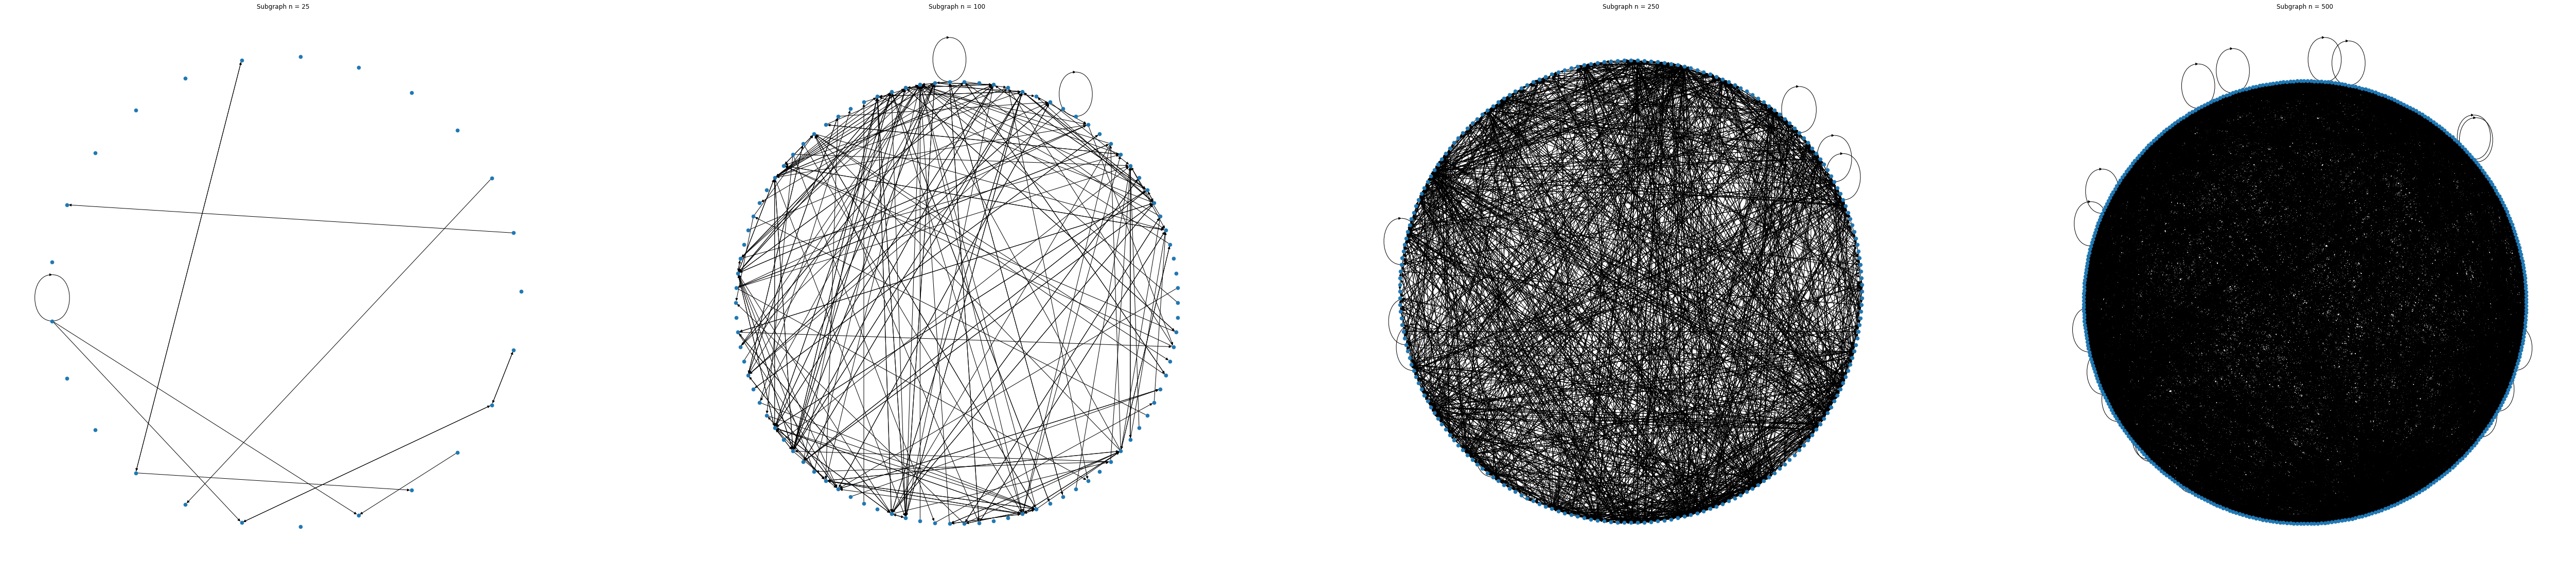

In [128]:
subgraph_sizes = [25, 100, 250, 500]

# get some axes for our graphs
fig, axes = plt.subplots(1, len(subgraph_sizes), figsize=(90, 20))

for ax, subgraph_size in zip(axes, subgraph_sizes):
  # build subgraph
  nodes = np.array(G.nodes)
  sub_nodes = np.random.choice(nodes, size = subgraph_size)

  SG = G.subgraph(sub_nodes)

  nodes = (SG.nodes)
  N_nodes = SG.number_of_nodes()

  pos = nx.circular_layout(SG)

  nx.draw(SG, pos=pos, arrows=True, node_size=50, linewidths=0.6, ax=ax)
  ax.set_aspect('equal')
  ax.set_title(f"Subgraph n = {subgraph_size}")

plt.show()

## Computing Semantic Similarity with Word2Vec

We now use `gensim` to load a Word2Vec embedding. The embedding used is `crawl-300d-2M.vec`, two million word vectors trained on the 600 billion token Common Crawl corpus. It can be downloaded from https://fasttext.cc/docs/en/english-vectors.html. As previously discussed, the embedding represents words in a 300 dimensional vector space, where the inner product of the vectors of two words corresponds to how commonly they occur in the same documents. 

Because the Common Crawl is a set of webpages, Wikipedia pages are likely included in the sample. As a result, the presence of a link on a Wikipedia page to another Wikipedia page would cause the titles to be more closely associated in the embedding, because the link and title being in the same page would represent a co-occurrence of the two terms or sets of terms. However, because Wikipedia represents a vanishingly small fraction of the web, the direct influence of this is minimal, and we will disregard it. 

In [129]:
MODEL_BIN = f'{DATA_DIR}/{COMPILED_MODEL}'
# save_name = MODEL_BIN[:-4] + ".d2v"

# MODEL = KeyedVectors.load_word2vec_format(MODEL_BIN)
# MODEL.save(save_name)

# loading model
model = KeyedVectors.load(MODEL_BIN)

# get words included in model
model_keys = model.index_to_key

## Hypothesis Test

We now proceed to test our hypothesis that the distance between a pair of articles on the Wikipedia graph is correlated with the semantic similarity between the titles of the articles. 

A slight issue is presented by the fact that Wikipedia distance is directional, whereas the semantic similarity is not. As a result, it's possible that the distance from article $A$ to article $B$ may differ from the distance from article $B$ to article $A$. Because the direction of a pair of articles is sampled randomly, there is no bias introduced by this unidirectional sample, so it's acceptable to compare only one direction's distance to the semantic similarity.

Generate k article pairs from top n:

In [130]:
k = 1000
columns = ['start','end','wikiDistance','semanticSimilarity']
k_pairs = pd.DataFrame(columns=columns)

for i in range(k):
	temp = df['page'].sample(n=2, random_state=i)
	start = temp.values[0]
	end = temp.values[1]

	if start not in list(G.nodes) or end not in list(G.nodes):
		continue

	# compute distance
	if nx.has_path(G, start, end):
		dist = len(nx.shortest_path(G, start, end)) - 1
	else:
		dist = -1

	# compute semantic similarity
	w1_tokens = start.split('_') # split into tokens
	w1_tokens = list(filter(lambda x: x in model_keys, w1_tokens)) # exclude terms not in embedding

	w2_tokens = end.split('_') 
	w2_tokens = list(filter(lambda x: x in model_keys, w2_tokens))

	# if the resulting page name is empty (none of the words are in our sem model), then ignore that page
	if len(w1_tokens) == 0 or len(w2_tokens) == 0:
		continue
	
	semSim = model.n_similarity(w1_tokens, w2_tokens)

	new_row = pd.DataFrame({'start': [start], 'end': [end], 'wikiDistance': [dist], 'semanticSimilarity':[semSim]})

	k_pairs = pd.concat([k_pairs, new_row])
	# k_pairs = pd.concat(k_pairs, {'start': start, 'end': end, 'wikiDistance': dist, 'semanticSimilarity':semSim}, ignore_index=True)

k_pairs

,start,end,wikiDistance,semanticSimilarity
0,Chloë_Grace_Moretz,Game_of_Thrones_(season_7),3,0.225844
0,Catherine_the_Great,Rashida_Jones,4,0.287651
0,Ted_Bundy,Kate_Beckinsale,3,0.372477
0,The_Good_Doctor_(TV_series),Sophie_Turner,3,0.269862
0,Oprah_Winfrey,Deadpool,2,0.118736
...,...,...,...,...
0,Priyanka_Chopra,Titanic_(1997_film),2,0.199602
0,George_Soros,Jessica_Chastain,3,0.286323
0,Courteney_Cox,Captain_Marvel_(film),2,0.251347
0,United_Kingdom,Emily_Blunt,3,0.162859


We now use Spearman's r test to compute the probability that there exists a statistically significant correlation between WikiDistance and Semantic Similarity. We should note that the Spearman correlation coefficent differs from the more standard Pearson correlation coefficent in that it measures how well a relationship is described by some monotonic function, as opposed to the Pearson coefficient which specifically measures the strength and direction of a linear relationship. We opt to use this measure of correlation because we have no reason to assume that a relationship between WikiDistance and Semantic Similarity will be linear.

In [131]:
corr, p_val = spearmanr(k_pairs['wikiDistance'], k_pairs['semanticSimilarity'])
print(f"correlation: {corr} p-value: {p_val}")

correlation: -0.14044628654083902 p-value: 1.5162329571589452e-05


Reasoning about our answer, we can conclude that WikiDistance and Semantic Similarity are weakly, negatively correlated. That being said, our p-value is incredibly small due to our large sample size. Thus, we can can confidently conclude that there does exist some relationship between WikiDistance and Semantic Similarity.

This correlation can be visualized on a violin plot of the semantic similarities of article pairs at each observed distance.

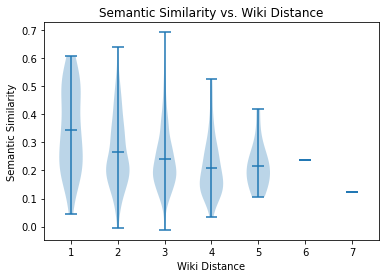

In [132]:
distances = [i for i in range(1, 8)]
similarities = [k_pairs[k_pairs['wikiDistance'] == i]['semanticSimilarity'].array for i in distances]

plt.violinplot(similarities, positions=distances, showmeans=True, showextrema=True)
plt.xticks(distances, distances)
plt.xlabel('Wiki Distance')
plt.ylabel('Semantic Similarity')
plt.title('Semantic Similarity vs. Wiki Distance')
plt.show()